# Setting up a marginal likelihood Gaussian process

Let us start by importing Turing.jl, the library we will use to write our statistical model and our GaussianProcess.jl package. \
The rest of the imports will only be used to generate the data and plot. 

In [1]:
using Turing
using GaussianProcess
using LinearAlgebra
using PyPlot
using Random


### 1. Make some fake data
Our code can deal with sparse data as well as error bars. \
Our goal in this example will be to capture sinusodial signal on top of the mean function. 

In [2]:
function make_mean(X)
    return @.(exp(-X) + 0.1*log(1+X))
end

make_mean (generic function with 1 method)

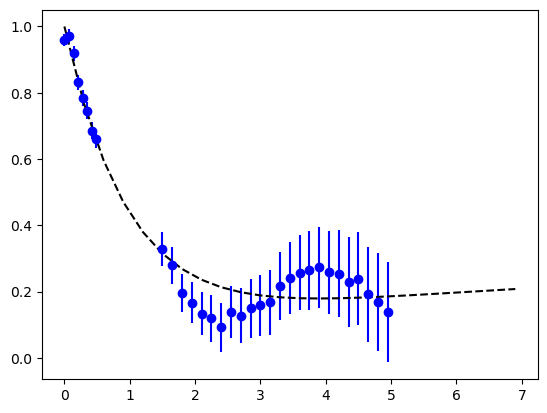

In [3]:
data_1_x = Vector(0:0.07:0.5)
data_2_x = Vector(1.5:0.15:5)
data_x = [data_1_x; data_2_x]
data = similar(data_x)
data[1:length(data_1_x), 1] = make_mean(data_1_x) .* (1 .+ randn(length(data_1_x)) .* 0.03)
data[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = make_mean(data_2_x) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))
data_err = vec(@.((0.02 * data) + (0.03 * data_x)))

N = length(data_err) 
data_cov = zeros(N, N)
for i in 1:N
    data_cov[i,i] = data_err[i]^2 
end

gp_x = Vector(0:0.3:7)
plt.errorbar(data_x, data, yerr=data_err, fmt="bo")
plt.plot(gp_x, make_mean(gp_x), "k--");

### 2. Define our statistical model

Fundamentally, a Gaussian process is a multivariate Gaussian distribution. As such, it is exclusively defined by a mean and a covariance function.  When our Gaussian Process is linearly related to the data, one can show that the contribution of each node of the Gaussian process (dimensions in the multivariate Normal) to a Gaussian likelihood can be analytically marginalized. Therefore we don't need to sample them as independent parameters in our model, greatly reducing the dimensions of parameter space.

In this scenario, all we need to care about are the statiscal properties of the ensemble controlled by its covariance matrix. The covariance matrix is normally parametrized in terms of so called hyper-parameters.

[Flesh out]

In [4]:
@model function stats_model(y, X; data_cov=data_cov)
    # Priors.
    eta ~ Exponential(1)
    l ~ Uniform(0.01, 3)
    
    # Realized covariance function
    K = sqexp_cov_fn(X; eta=eta, l=l) 
    mean = make_mean(X)
    y ~ marginal_lkl(mean, K; data_cov=data_cov)
end

stats_model (generic function with 2 methods)

### 3. Sample the model

In [5]:
chain = sample(stats_model(data, data_x), HMC(0.01, 100), 1000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16


Chains MCMC chain (1000×11×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 25.16 seconds
Compute duration  = 25.16 seconds
parameters        = eta, l
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

         eta    0.0223    0.0827     0.0026    0.0063   196.1610    1.0015     ⋯
           l    1.4238    0.7613     0.0241    0.0603   127.2791    0.9990     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         eta    0.0002    0.0019    0.0047    0.0142    0.1558
     

### 4. Predict value of Guassian process at points of interest

In [6]:
etas = group(chain, :eta).value.data[:, :, 1]
ls = group(chain, :l).value.data[:, :, 1];

In [7]:
mean_old = make_mean(data_x)
mean_new = make_mean(gp_x)

gp_predict = posterior_predict(gp_x, data_x, mean_new, mean_old, data,
                                sqexp_cov_fn; data_cov=data_cov)
ynew = [rand(gp_predict(eta=etas[m], l=ls[m])) for m in 1:length(etas)]
ynew = hcat(ynew...);

In [8]:
pred_mean = mean(ynew, dims=2)
pred_std = std(ynew, dims=2);

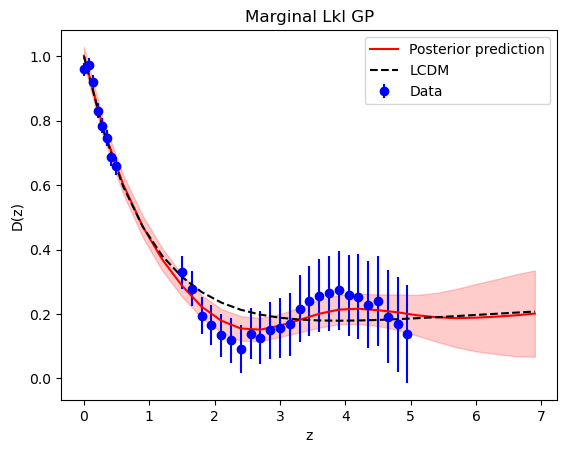

In [9]:
plt.errorbar(data_x, data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, vec(pred_mean), color="red",
         label="Posterior prediction")
plt.fill_between(gp_x, vec(pred_mean .+ pred_std),
                 vec(pred_mean .- pred_std), color="red",
                 alpha=0.2)
plt.plot(gp_x, make_mean(gp_x), "k--", label="LCDM")
plt.xlabel("z")
plt.ylabel("D(z)")
plt.title("Marginal Lkl GP")
plt.legend()
#plt.legend(loc="lower right")
#plt.title("GP Posterior predictive with 95% credible interval");